# 🚧 Info

https://huggingface.co/datasets/pyronear/pyro-sdis

https://frugalaichallenge.org/participate/

- tester si amélioration avec et sans égalisation

# Image task notebook template
## Loading the necessary libraries

In [1]:
from fastapi import APIRouter
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score

import yaml
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from scipy.ndimage import median_filter

from src.load_data import load_data
from src.models import eval_pretrained_model, ConditionalAugmentation
from tasks.utils.evaluation import ImageEvaluationRequest
from tasks.utils.emissions import tracker, clean_emissions_data, get_space_info
from tasks.image import parse_boxes,compute_iou,compute_max_iou

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

/Users/julmat/Documents/hugging_face/frugal_cviz/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[codecarbon WARNING @ 17:05:07] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:05:07] [setup] RAM Tracking...
[codecarbon INFO @ 17:05:07] [setup] CPU Tracking...
[codecarbon WARNING @ 17:05:08] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 17:05:08] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 17:05:08] [setup] GPU Tracking...
[codecarbon INFO @ 17:05:08] No GPU found.
[codecarbon INFO @ 17:05:08] >>> Tracker's metadata:
[codecarbon INFO @ 17:05:08]   Platform system: macOS-15.2-arm64-arm-64bit
[codecarbon INFO @ 17

## Load config

In [2]:
# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
OUTPUT_DIR = cfg["data_dir"]
DB_INFO_URI = cfg["db_info_uri"]

## Load data

In [3]:
request = ImageEvaluationRequest()
# Define paths
REPO_ID = request.dataset_name
# Load data and export in Ultralytics format
# ⚠️ clear cache folder after it is done
df = load_data(OUTPUT_DIR, REPO_ID, DB_INFO_URI)

In [4]:
df

width  height format mode  \
0       1280     720   JPEG  RGB   
1       1280     720   JPEG  RGB   
2       1280     720   JPEG  RGB   
3       1280     720   JPEG  RGB   
4       1280     720   JPEG  RGB   
...      ...     ...    ...  ...   
33631   1280     720   JPEG  RGB   
33632   1280     720   JPEG  RGB   
33633   1280     720   JPEG  RGB   
33634   1280     720   JPEG  RGB   
33635   1280     720   JPEG  RGB   

                                                  name  \
0           sdis-07_brison-110_2024-09-05T11-05-43.jpg   
1            sdis-07_brison-20_2024-02-05T16-59-10.jpg   
2            sdis-07_brison-20_2024-02-05T17-19-11.jpg   
3           sdis-07_brison-226_2024-09-15T15-17-58.jpg   
4            sdis-07_brison-20_2024-02-06T13-16-28.jpg   
...                                                ...   
33631       sdis-07_brison-200_2024-01-24T15-54-58.jpg   
33632  force-06_courmettes-275_2024-02-28T13-15-08.jpg   
33633  force-06_courmettes-160_2024-04-20T18-32-12.jpg   
33634   sdis-07_marguerite-339_2024-02-07T17-00-13.jpg   
33635       sdis-07_brison-110_2024-02-21T11-30-17.jpg   

                                                     uri  \
0      data/images/val/sdis-07_brison-110_2024-09-05T...   
1      data/images/val/sdis-07_brison-20_2024-02-05T1...   
2      data/images/val/sdis-07_brison-20_2024-02-05T1...   
3      data/images/val/sdis-07_brison-226_2024-09-15T...   
4      data/images/val/sdis-07_brison-20_2024-02-06T1...   
...                                                  ...   
33631  data/images/train/sdis-07_brison-200_2024-01-2...   
33632  data/images/train/force-06_courmettes-275_2024...   
33633  data/images/train/force-06_courmettes-160_2024...   
33634  data/images/train/sdis-07_marguerite-339_2024-...   
33635  data/images/train/sdis-07_brison-110_2024-02-2...   

                                             annotations   partner  \
0      1 0.082372 0.572803 0.028621599999999997 0.047...   sdis-07   
1      1 0.568154 0.353062 0.027667000000000108 0.033...   sdis-07   
2      1 0.560564 0.349347 0.028460699999999894 0.037...   sdis-07   
3      1 0.099354 0.702043 0.021461200000000014 0.028...   sdis-07   
4      1 0.564186 0.429952 0.04552620000000007 0.1073...   sdis-07   
...                                                  ...       ...   
33631  1 0.127209 0.626804 0.007731270000000012 0.018...   sdis-07   
33632  1 0.0931379 0.430174 0.01030020000000001 0.018...  force-06   
33633  1 0.03690439999999999 0.696173 0.0712459 0.092...  force-06   
33634                                                NaN   sdis-07   
33635  1 0.427088 0.65522 0.018086399999999947 0.0462...   sdis-07   

               camera            timestamp  
0          brison-110  2024-09-05T11-05-43  
1           brison-20  2024-02-05T16-59-10  
2           brison-20  2024-02-05T17-19-11  
3          brison-226  2024-09-15T15-17-58  
4           brison-20  2024-02-06T13-16-28  
...               ...                  ...  
33631      brison-200  2024-01-24T15-54-58  
33632  courmettes-275  2024-02-28T13-15-08  
33633  courmettes-160  2024-04-20T18-32-12  
33634  marguerite-339  2024-02-07T17-00-13  
33635      brison-110  2024-02-21T11-30-17  

[33636 rows x 10 columns]

## EDA

In [5]:
df.describe(include='all')

width   height format   mode  \
count   33636.0  33636.0  33636  33636   
unique      NaN      NaN      1      1   
top         NaN      NaN   JPEG    RGB   
freq        NaN      NaN  33636  33636   
mean     1280.0    720.0    NaN    NaN   
std         0.0      0.0    NaN    NaN   
min      1280.0    720.0    NaN    NaN   
25%      1280.0    720.0    NaN    NaN   
50%      1280.0    720.0    NaN    NaN   
75%      1280.0    720.0    NaN    NaN   
max      1280.0    720.0    NaN    NaN   

                                              name  \
count                                        33636   
unique                                       33636   
top     sdis-07_brison-110_2024-09-05T11-05-43.jpg   
freq                                             1   
mean                                           NaN   
std                                            NaN   
min                                            NaN   
25%                                            NaN   
50%                                            NaN   
75%                                            NaN   
max                                            NaN   

                                                      uri  \
count                                               33636   
unique                                              33636   
top     data/images/val/sdis-07_brison-110_2024-09-05T...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                              annotations  partner  \
count                                               28103    33636   
unique                                              27247        3   
top     1 0.0776863 0.568912 0.029480299999999987 0.08...  sdis-07   
freq                                                    6    17766   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

            camera            timestamp  
count        33636                33636  
unique          40                33464  
top     brison-200  2024-01-20T10-47-07  
freq          4971                    3  
mean           NaN                  NaN  
std            NaN                  NaN  
min            NaN                  NaN  
25%            NaN                  NaN  
50%            NaN                  NaN  
75%            NaN                  NaN  
max            NaN                  NaN

width                                                       1280
height                                                       720
format                                                      JPEG
mode                                                         RGB
name                   sdis-07_brison-20_2024-02-05T17-19-11.jpg
uri            data/images/val/sdis-07_brison-20_2024-02-05T1...
annotations    1 0.560564 0.349347 0.028460699999999894 0.037...
partner                                                  sdis-07
camera                                                 brison-20
timestamp                                    2024-02-05T17-19-11
Name: 2, dtype: object


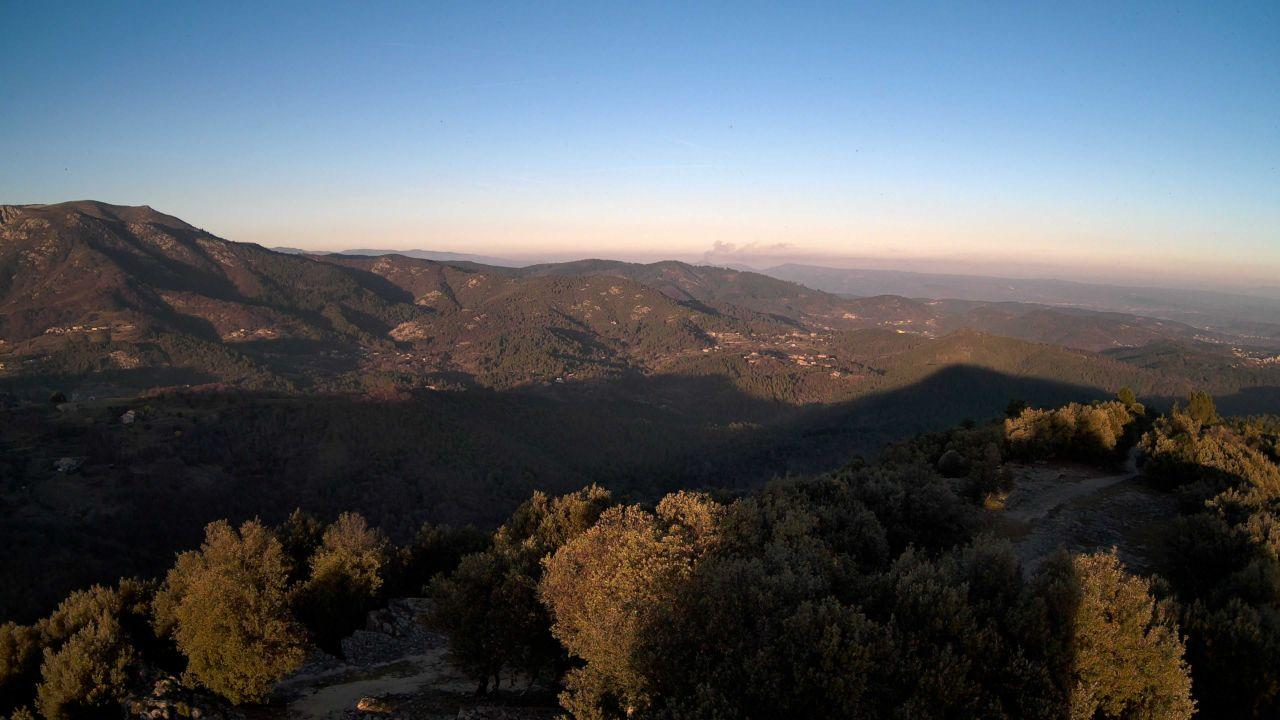

In [16]:
choice = 2

_ = df.loc[choice]
print(_)
img = Image.open(_.uri)
display(img)

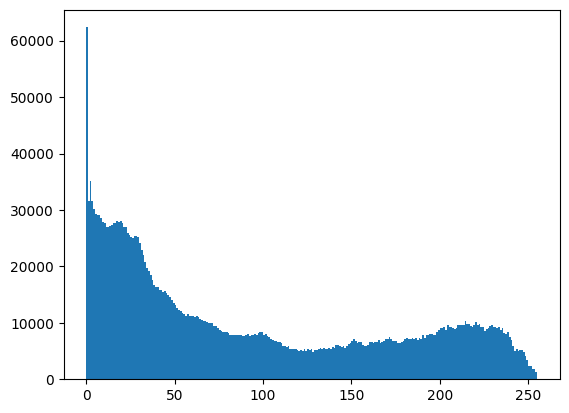

In [17]:
img_arr = np.array(img)
# display histogram
# normalization: use density=True in plt.hist
# for a cumulative histogram: use cumulative=True
n, bins, patches = plt.hist(img_arr.flatten(), bins=range(256))
plt.show()

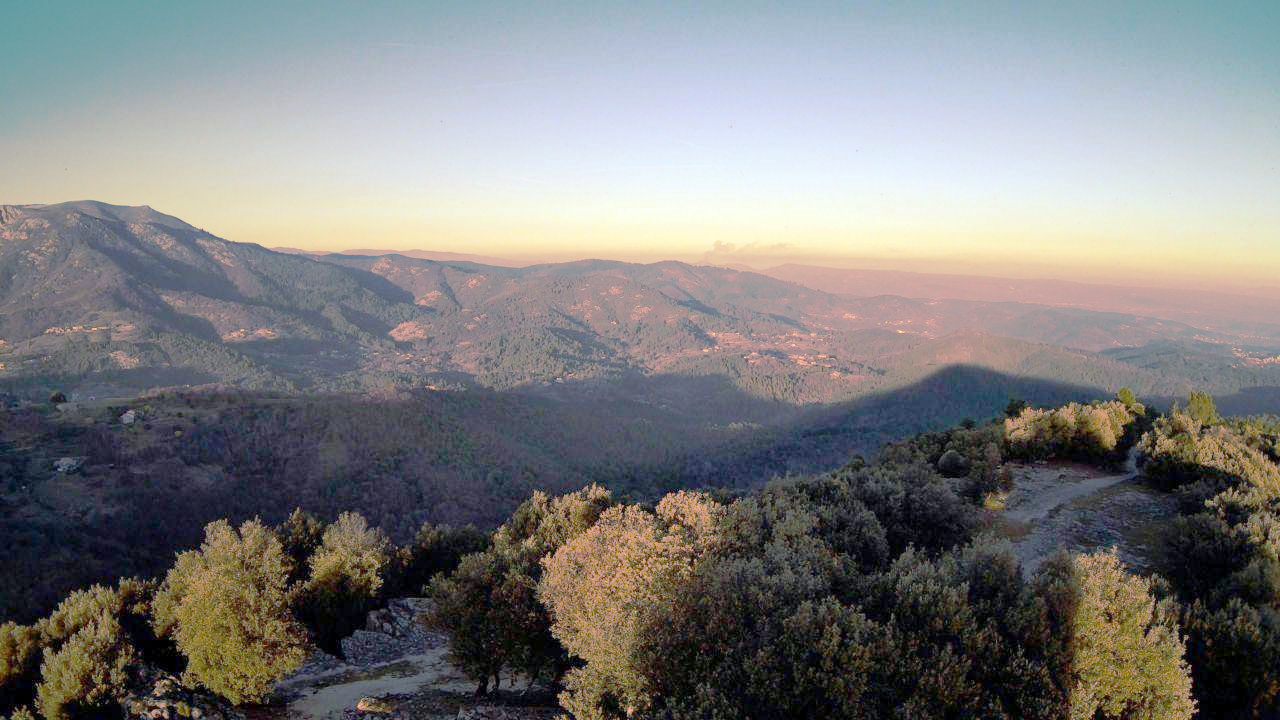

In [18]:
eq_img = ImageOps.equalize(img)
eq_img

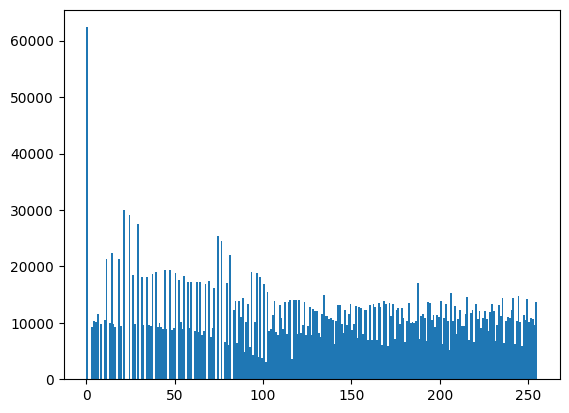

In [19]:
eq_img_arr = np.array(eq_img)
n, bins, patches = plt.hist(eq_img_arr.flatten(), bins=range(256))
plt.show()

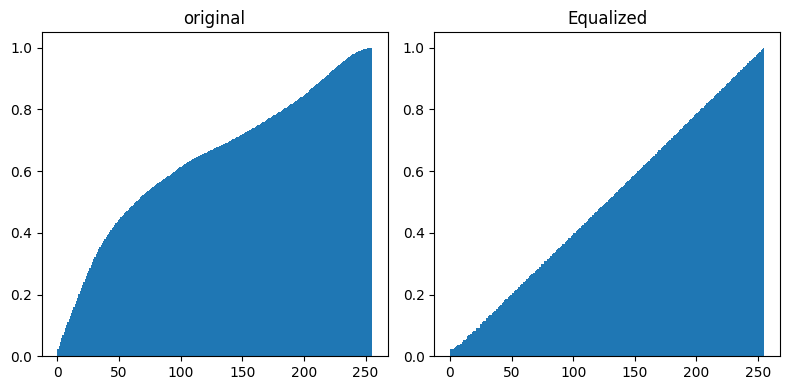

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.hist(img_arr.flatten(), bins=range(256), cumulative=True, density=True)
ax1.set_title("original")

ax2.hist(eq_img_arr.flatten(), bins=range(256), cumulative=True, density=True)
ax2.set_title("Equalized")

plt.tight_layout()
plt.show()

In [11]:
# from sklearn.model_selection import train_test_split ???


# # Split dataset
# train_test = ds["train"].train_test_split(test_size=request.test_size, seed=request.test_seed)
# ds_train = train_test["train"]
# ds_test = train_test["test"]
# ds_val = ds["val"]

# print(f"Complete dataset: {ds.shape}")
# print(f"Train dataset: {ds_train.shape}")
# print(f"Test dataset: {ds_test.shape}")
# print(f"Validation dataset: {ds_val.shape}")

Train EfficientNet

In [12]:
# import tensorflow as tf
# from keras.applications import EfficientNetB0

# model_name = "EfficientNetB0"

# # load pre-trained model without top layers
# model = EfficientNetB0(
#     weights="imagenet",  # pre-trained weights
#     include_top=False,  # no dense layer
#     input_shape=(input_size[0], input_size[1], 3),  # input shape
# )
# # create explicit input layer
# inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# # add data augmentation
# augmented = ConditionalAugmentation(rate=0.4)(inputs)
# x = model(augmented)

# # flatten output
# x = Flatten()(x)
# # for feature extraction only
# for layer in model.layers:
#     layer.trainable = False
# # new FC layer for 3 classes classification
# predictions = Dense(3, activation="softmax")(x)
# # define new model
# effnetB0 = Model(inputs=inputs, outputs=predictions)
# # display model summary
# effnetB0.summary()

config commune

In [13]:
# input_size = (224, 224)
# batch_size = 48
# n_epochs = 100
# optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
# loss = "sparse_categorical_crossentropy"
# metrics = ["accuracy"]

In [14]:
# model_trained, history = eval_pretrained_model(
#     model=insert_model_here,
#     train_ds=insert_train_ds_here,
#     val_ds=insert_val_ds_here,
#     test_ds=insert_test_ds_here,
#     LOG_DIR=LOG_DIR,
#     CHKPT_DIR=CHKPT_DIR,
#     model_name=model_name,
#     input_size=input_size,
#     batch_size=batch_size,
#     n_epochs=n_epochs,
#     optimizer=optimizer,
#     loss=loss,
#     metrics=metrics,
# )

## 🚧 Code JL

In [15]:
stop

NameError: name 'stop' is not defined

**Training** with Ultralytics YOLO

In [ ]:
# from huggingface_hub import hf_hub_download

# # Correctly set repo_id and repo_type
# repo_id = "pyronear/pyro-sdis"
# filename = "data.yaml"

# # Download data.yaml to the current directory
# yaml_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset", local_dir=".")
# print(f"data.yaml downloaded to: {yaml_path}")

Train with Yolo (command line)

In [ ]:
# yolo task=detect mode=train data=data.yaml model=yolov8n.pt epochs=50 imgsz=640 single_cls=True

## 🚧 fin Code JL

## Random Baseline

In [8]:
# Start tracking emissions
tracker.start()
tracker.start_task("inference")

[codecarbon WARNING @ 17:11:39] Already started tracking
[codecarbon INFO @ 17:11:39] A task is already under measure


In [11]:

#--------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE CODE HERE
# Update the code below to replace the random baseline by your model inference within the inference pass where the energy consumption and emissions are tracked.
#--------------------------------------------------------------------------------------------

# Make random predictions (placeholder for actual model inference)

predictions = []
true_labels = []
pred_boxes = []
true_boxes_list = []  # List of lists, each inner list contains boxes for one image

for example in test_dataset:
    # Parse true annotation (YOLO format: class_id x_center y_center width height)
    annotation = example.get("annotations", "").strip()
    has_smoke = len(annotation) > 0
    true_labels.append(int(has_smoke))
    
    # Make random classification prediction
    pred_has_smoke = random.random() > 0.5
    predictions.append(int(pred_has_smoke))
    
    # If there's a true box, parse it and make random box prediction
    if has_smoke:
        # Parse all true boxes from the annotation
        image_true_boxes = parse_boxes(annotation)
        true_boxes_list.append(image_true_boxes)
        
        # For baseline, make one random box prediction per image
        # In a real model, you might want to predict multiple boxes
        random_box = [
            random.random(),  # x_center
            random.random(),  # y_center
            random.random() * 0.5,  # width (max 0.5)
            random.random() * 0.5   # height (max 0.5)
        ]
        pred_boxes.append(random_box)


#--------------------------------------------------------------------------------------------
# YOUR MODEL INFERENCE STOPS HERE
#--------------------------------------------------------------------------------------------   

In [9]:
# Stop tracking emissions
emissions_data = tracker.stop_task()

[codecarbon WARNING @ 17:12:24] Background scheduler didn't run for a long period (1885s), results might be inaccurate
[codecarbon INFO @ 17:12:24] Energy consumed for RAM : 0.003142 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:12:24] Energy consumed for all CPUs : 0.002618 kWh. Total CPU Power : 5.0 W
[codecarbon INFO @ 17:12:24] 0.005760 kWh of electricity used since the beginning.


In [12]:
import numpy as np

# Calculate classification metrics
classification_accuracy = accuracy_score(true_labels, predictions)
classification_precision = precision_score(true_labels, predictions)
classification_recall = recall_score(true_labels, predictions)

# Calculate mean IoU for object detection (only for images with smoke)
# For each image, we compute the max IoU between the predicted box and all true boxes
ious = []
for true_boxes, pred_box in zip(true_boxes_list, pred_boxes):
    max_iou = compute_max_iou(true_boxes, pred_box)
    ious.append(max_iou)

mean_iou = float(np.mean(ious)) if ious else 0.0

In [13]:

# Prepare results dictionary
results = {
    "submission_timestamp": datetime.now().isoformat(),
    "classification_accuracy": float(classification_accuracy),
    "classification_precision": float(classification_precision),
    "classification_recall": float(classification_recall),
    "mean_iou": mean_iou,
    "energy_consumed_wh": emissions_data.energy_consumed * 1000,
    "emissions_gco2eq": emissions_data.emissions * 1000,
    "emissions_data": clean_emissions_data(emissions_data),
    "dataset_config": {
        "dataset_name": request.dataset_name,
        "test_size": request.test_size,
        "test_seed": request.test_seed
    }
}
results

{'submission_timestamp': '2025-01-23T17:13:47.158903',
 'classification_accuracy': 0.4974610697359513,
 'classification_precision': 0.8362892223738063,
 'classification_recall': 0.49625581866019025,
 'mean_iou': 0.0026954029097350594,
 'energy_consumed_wh': 5.759879923426909,
 'emissions_gco2eq': 0.2006914961719638,
 'emissions_data': {'run_id': 'fbab9dd9-2893-4216-91c4-232be358d4dd',
  'duration': 1885.054949500016,
  'emissions': 0.0002006914961719638,
  'emissions_rate': 1.0646457428260931e-07,
  'cpu_power': 5.0,
  'gpu_power': 0.0,
  'ram_power': 6.0,
  'cpu_energy': 0.002618128800231918,
  'gpu_energy': 0,
  'ram_energy': 0.0031417511231949906,
  'energy_consumed': 0.005759879923426909,
  'country_name': 'Switzerland',
  'country_iso_code': 'CHE',
  'region': 'zurich',
  'cloud_provider': '',
  'cloud_region': '',
  'os': 'macOS-15.2-arm64-arm-64bit',
  'python_version': '3.12.7',
  'codecarbon_version': '2.8.3',
  'cpu_count': 8,
  'cpu_model': 'Apple M1',
  'gpu_count': None,
 